In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
data = pd.read_csv('credit_card_default_analysis.csv', index_col='ID')
_data = data.copy()

data.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,0,0,0,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,0,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,0,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [4]:
def print_plots(data1, data2, label1, label2, boxplot_label='', hist_label='', show_boxplot=True):
    if show_boxplot:
        plt.figure(figsize=(14, 8))
        plt.boxplot([data1, data2], labels=[label1, label2])
        plt.ylabel(boxplot_label)
        plt.show()

    plt.figure(figsize=(16, 7))

    plt.subplot(121)
    plt.hist(data1, label=label1)
    plt.xlabel(label1)
    plt.ylabel(hist_label)

    plt.subplot(122)
    plt.hist(data2, label=label2)
    plt.xlabel(label2)
    plt.ylabel(hist_label)
    plt.show()

In [7]:
def get_bootstrap_samples(data, n_samples=100):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples
def stat_intervals(stat, alpha=0.05):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

def get_random_combinations(n1, n2, max_combinations):
    index = list(range(n1 + n2))
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

def permutation_zero_dist_ind(sample1, sample2, max_combinations=None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr

def permutation_test(sample1, sample2, max_permutations=500, alternative='two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample1, sample2)
    
    zero_distr = permutation_zero_dist_ind(sample1, sample2, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

## Решение 1.а

Будем проверять гипотезу c помощью бутстрапа:

H0: медианы выборок LIMIL_BAL для людей, вернувших и невернувших кредиты, равны

С альтернативой:

H1: не равны

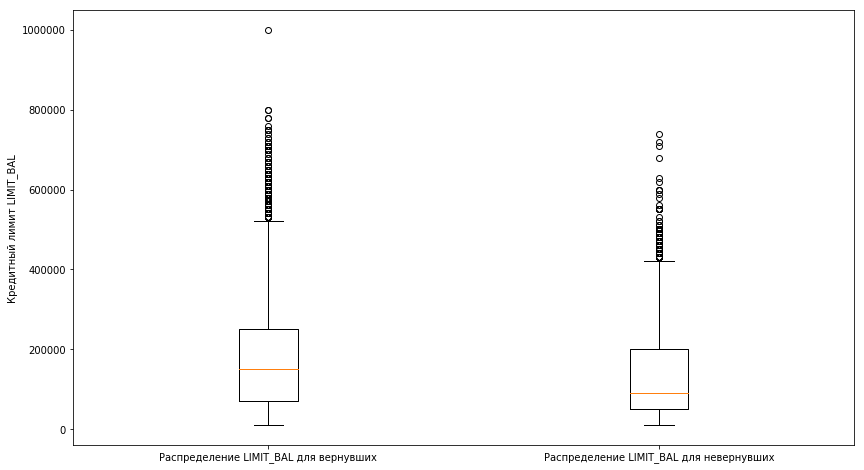

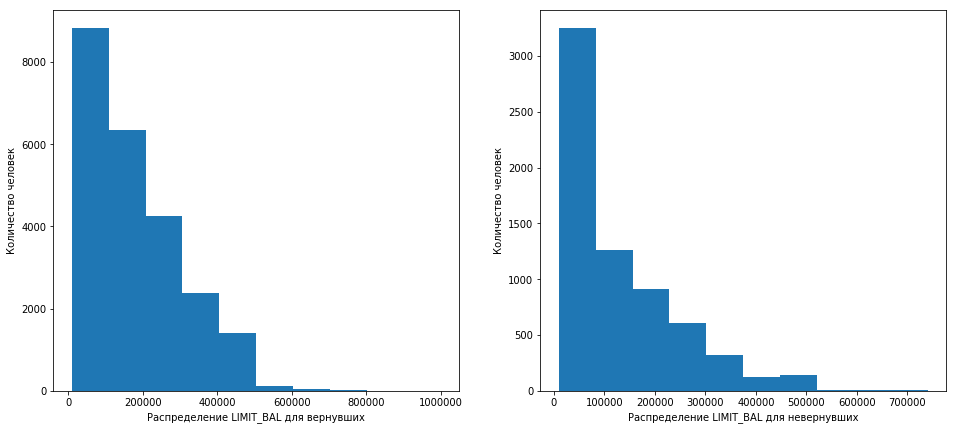

median1 = 150000.0, median2 = 90000.0
median diff 95% interval = [60000. 70000.]


In [39]:
from scipy.stats import median_test

returned = data[data.default == 0]
not_returned = data[data.default == 1]
    
print_plots(returned.LIMIT_BAL, not_returned.LIMIT_BAL, 
            label1 = 'Распределение LIMIT_BAL для вернувших',
            label2 = 'Распределение LIMIT_BAL для невернувших',
            boxplot_label = 'Кредитный лимит LIMIT_BAL',
            hist_label = 'Количество человек')

samples1 = np.array(list( map( np.median, get_bootstrap_samples(returned.LIMIT_BAL.values, 200) ) ) )
samples2 = np.array(list( map( np.median, get_bootstrap_samples(not_returned.LIMIT_BAL.values, 200) )  ) )

    
print('median1 = {}, median2 = {}'.format(returned.LIMIT_BAL.median(), not_returned.LIMIT_BAL.median()))
print('median diff 95% interval = {}'.format(stat_intervals(samples1 - samples2) ))

### Вывод: интервал не пересекается, что говорит о статистическом различии медиан. И различия медиан в 90 тысяч и 150 тоже практически значимы.

## Решение 1.б

H0: Распределения returned и not_returned равны

H1: Распределения смещены друг относительно друга
    
Будем использовать критерий Манна-Уитни

In [5]:
from scipy.stats import mannwhitneyu

_, pvalue = mannwhitneyu(returned, not_returned, alternative='two-sided')

print('mean(returned)={}, mean(not_returned)={}\npvalue = {}'.format(returned.mean(), not_returned.mean(), pvalue))

mean(returned)=178099.72607430234, mean(not_returned)=130109.65641952984
pvalue = 1.2255485818223303e-189


### Вывод: pvalue мало, следовательно кредитные лимиты в выборках имеют разные распределения. Различие медиан и средних практически значимо.

## Решение 2

p1 - доля мужчин, вернувших долг
p2 - доля женщин, вернувших долг

используем двухсторонний z-критерий для доли двух независимых выборок

H0: p1 и p2 равны

H1: не равны

In [14]:
from scipy.stats import norm
def z_test_binom_ind(sample1, sample2):
    p1 = np.mean(sample1)
    n1 = len(sample1)
    p2 = np.mean(sample2)
    n2 = len(sample2)
    
    P = (p1 * n1 + p2 * n2) / (n1 + n2)
    
    statistics = (p1 - p2) / np.sqrt(P * (1 - P) * (1 / n1 + 1 / n2))
    pvalue = 2 * (1 - norm.cdf(np.abs(statistics)))
    
    return (statistics, pvalue)

In [15]:
def z_confint_one(values, alpha=0.05):
    p = np.mean(values)
    n = len(values)
    
    delta = norm.ppf(1 - alpha / 2) * np.sqrt(p * (1 - p) / n)
    
    return [max(p - delta, 0), min(p + delta, 1)]

def z_confint_ind(sample1, sample2, alpha=0.05):
    p1 = np.mean(sample1)
    n1 = len(sample1)
    p2 = np.mean(sample2)
    n2 = len(sample2)
    
    diff = p1 - p2
    
    delta = norm.ppf(1 - alpha / 2) * np.sqrt(p1 * (1 - p1) / n1 + p2 * (1 - p2) / n2)
    
    return [diff - delta, diff + delta]

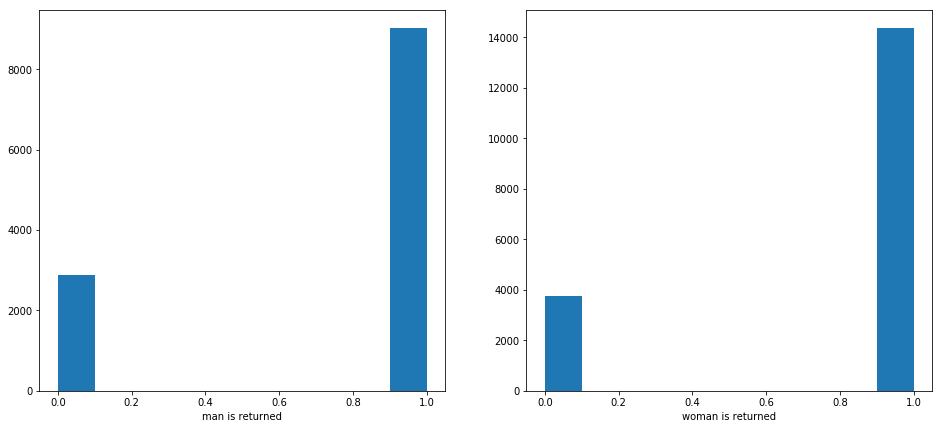

95%-доверительный интервал возврата для мужчин - 75.1%-76.6%
95%-доверительный интервал возврата для женщин - 78.6%-79.8%
95%-доверительный интервал разности долей женщин и мужчин - 2.4%-4.4%
z-statistics=-6.921375088562891, pvalue=4.472866521609831e-12


In [18]:
man_is_returned = data[data.SEX == 1].default.map(lambda x: x == 0)
woman_is_returned = data[data.SEX != 1].default.map(lambda x: x == 0)

print_plots(man_is_returned.astype('int'),
            woman_is_returned.astype('int'), 
            'man is returned', 
            'woman is returned', 
            show_boxplot=False)

zstats, pvalue = z_test_binom_ind(man_is_returned, woman_is_returned)

print('95%-доверительный интервал возврата для мужчин - {:.1%}-{:.1%}'.format(*z_confint_one(man_is_returned)))
print('95%-доверительный интервал возврата для женщин - {:.1%}-{:.1%}'.format(*z_confint_one(woman_is_returned)))
print('95%-доверительный интервал разности долей женщин и мужчин - {:.1%}-{:.1%}'.format(*z_confint_ind(woman_is_returned, man_is_returned)))

print('z-statistics={}, pvalue={}'.format(zstats, pvalue))

### Вывод: женщины возвращают на 3.39% ([2.4%, 4.36%] - 95%-доверительный интервал) чаще, чем мужчины. Причем т. к. pvalue мало, выбирается альтернатива: p1 и p2 не равны.

## Решение 3

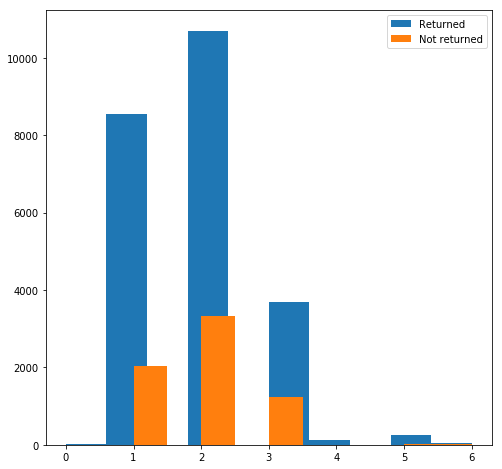

In [19]:
returned = data[data.default == 0]
not_returned = data[data.default == 1]

plt.figure(figsize=(8, 8))
plt.hist(returned.EDUCATION, label='Returned')
plt.hist(not_returned.EDUCATION, label='Not returned')
plt.legend()
plt.show()

In [20]:
data[['EDUCATION', 'default']].groupby(['default', 'EDUCATION']).size()

default  EDUCATION
0        0               14
         1             8549
         2            10700
         3             3680
         4              116
         5              262
         6               43
1        1             2036
         2             3330
         3             1237
         4                7
         5               18
         6                8
dtype: int64

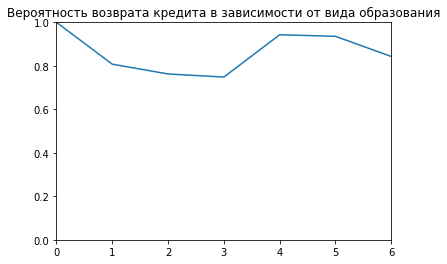

In [34]:
proba_of_return = []
count_by_edu = []
returned_by_edu = []
for education in range(7):
    cur = data[ data.EDUCATION == education ]
    ret_len = (cur.default == 0).sum()
    proba = ret_len / len(cur)
    
    proba_of_return.append(proba)
    count_by_edu.append( len(cur) )
    returned_by_edu.append( ret_len )

plt.title('Вероятность возврата кредита в зависимости от вида образования')
plt.plot(proba_of_return)
plt.axis([0, 6, 0, 1]);

### Вывод: чаще всего возвращают кредит доктора (0 по оси абсцисс), реже всего закончившие школу (3 по оси абсцисс)

### Проверим вывод с помощью критерия Хи-квадрат:

H0: рассматривая величина имеет равномерное распределение

H1: H0 не верна

In [35]:
prob_mean = np.mean(proba_of_return)

prob_mean

0.8629526580788338

In [36]:
from scipy.stats import chisquare

chisquare(returned_by_edu, [ prob_mean * num for num in count_by_edu ], ddof=1)

Power_divergenceResult(statistic=278.7725391716089, pvalue=3.653181595163598e-58)

### Вывод: критерий хи квадрат применим, гипотеза H0 отвергается. Выдача кредита зависит от вида образования как статистически, так и практически.

## Решение 4

H0: возрат кредита не зависит от семейного статуса

H1: возрат кредита зависит от семейного статуса

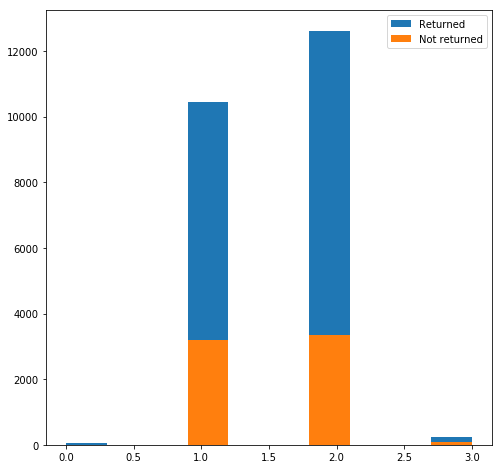

In [12]:
plt.figure(figsize=(8, 8))

plt.hist(returned.MARRIAGE, label='Returned')
plt.hist(not_returned.MARRIAGE, label='Not returned')
plt.legend()
plt.show()

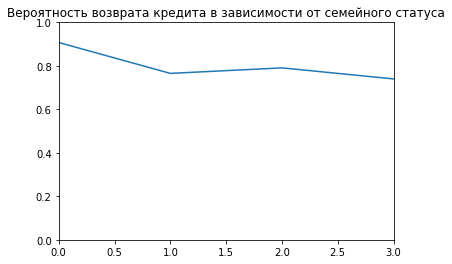

In [13]:
proba_of_return = []
for mar in range(4):
    cur = data[ data.MARRIAGE == mar ]
    proba = (cur.default == 0).sum() / len(cur)
    
    proba_of_return.append(proba)

plt.title('Вероятность возврата кредита в зависимости от семейного статуса')
plt.plot(proba_of_return)
plt.axis([0, 3, 0, 1]);

### Воспользуемся коэффициентом V Крамера:

In [37]:
con_table = np.zeros((2, 4), dtype='int')
for mar in range(4):
    con_table[0, mar] = (returned.MARRIAGE == mar).sum()
    con_table[1, mar] = (not_returned.MARRIAGE == mar).sum()

con_table = con_table.T
print('Таблица сопряженности:')
con_table

Таблица сопряженности:


array([[   49,     5],
       [10453,  3206],
       [12623,  3341],
       [  239,    84]])

In [28]:
def cramers_stat(confusion_matrix):
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    return np.sqrt(chi2 / (n*(min(confusion_matrix.shape)-1)))

In [29]:
cramers_stat(con_table)

0.034478203662766466

### Вывод: условия применимости критерия хи-2 выполнены. Коэффициент принимает близкое к нулю значение, следовательно взаимосвязь признаков отсутствует

## Решение 5.а

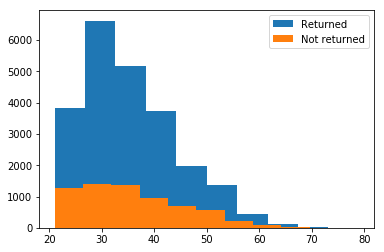

In [31]:
plt.hist(returned.AGE, label='Returned')
plt.hist(not_returned.AGE, label='Not returned')
plt.legend()
plt.show()

In [32]:
returned.AGE.median(), not_returned.AGE.median()

(34.0, 34.0)

Доверительный интервал разницы медиан через метод бутстрепа:

In [47]:
N = 200
returned_medians = np.array( list(map(np.median, get_bootstrap_samples(returned.AGE.values, N))) )
not_returned_medians = np.array( list(map(np.median, get_bootstrap_samples(not_returned.AGE.values, N)) ))

In [54]:
print('Доверительный интервал для разности медиан: [{}; {}]'.format(
    *stat_intervals(returned_medians - not_returned_medians)
))

Доверительный интервал для разности медиан: [-1.0; 0.0]


### Вывод: т. к. 0 включается в доверительный интервал, это говорит о том, что возвраст не влияет на возврат кредита. Этот результат практически значим

## Решение 5.б

Проверим двустороннюю с помощью критерия Манна-Уитни:

H0: распределения выборок равны

H1: распределения выборок различны

In [41]:
from scipy.stats import mannwhitneyu

mannwhitneyu(returned.AGE.values, not_returned.AGE.values)

MannwhitneyuResult(statistic=76966879.5, pvalue=0.1862517717449308)

In [65]:
returned.AGE.mean(), not_returned.AGE.mean()

(35.417265879130284, 35.72573839662447)

### Вывод: с alpha=0.05 можем говорить о том, что распределения статистически не различимы.